In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import librosa
import csv
import scipy
import matplotlib.pyplot as plt
import os
from IPython.display import Audio
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 
import librosa.display
from sklearn.model_selection import train_test_split, cross_validate

# Modelo Random Forest para Clasificación de Emociones através de Audio

# Modelo de Red Profunda

Para compilar este archivo que presenta el modelo de Red Profunda para la clasificación de emociones se debe descargar previamente el siguiente Dataset: [Dataset de Speech Emotions](https://www.kaggle.com/datasets/uldisvalainis/audio-emotions/download?datasetVersionNumber=1 ), que contiene 12.782 audios distribuidos en 7 categorias que son: Angry (0) Disgusted(1), Fearful(2), Happy(3), Neutral(4), Sad(5) y Surprised(6). 

El modelo esta compuesto por 5 capas: 1 entrada, 1 salida y 3 capas ocultas.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ML Proyecto # adicionar la ruta del proyecto

/content/drive/MyDrive/ML Proyecto


## Análisis y procesamiento de Audio

In [ ]:
# Poner aqui la ruta del dataset de speech emotions previamente cargado
DATASET = 'Dataset/Emotions/' # aqui poner la ruta del dataset

In [ ]:
paths=[]
labels=[]

for dirname, _, filenames in os.walk(DATASET):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename[::-1].split('.')[0][::-1]
        name = dirname[::].split('/')[2]
        name_complete = name+'.'+label
        labels.append(name_complete.lower())

In [ ]:
data = pd.DataFrame({'speech':paths,'label':labels})
data.sample(10) # Retorna una muestra de items aleatoria

,speech,label
9234,Dataset/Emotions/Neutral/su04.wav,neutral.wav
1827,Dataset/Emotions/Angry/1049_IWW_ANG_XX.wav,angry.wav
6954,Dataset/Emotions/Happy/YAF_vine_happy.wav,happy.wav
3540,Dataset/Emotions/Disgusted/1020_IEO_DIS_MD.wav,disgusted.wav
4533,Dataset/Emotions/Fearful/OAF_kick_fear.wav,fearful.wav
11266,Dataset/Emotions/Sad/1004_ITH_SAD_XX.wav,sad.wav
604,Dataset/Emotions/Angry/1088_WSI_ANG_XX.wav,angry.wav
1178,Dataset/Emotions/Angry/03-02-05-02-02-02-01.wav,angry.wav
7836,Dataset/Emotions/Happy/1049_IEO_HAP_HI.wav,happy.wav
2112,Dataset/Emotions/Angry/03-01-05-02-01-02-20.wav,angry.wav


In [ ]:
# Convierte las clase no numericas a numericas. 
label_encoder = preprocessing.LabelEncoder()
data['label'] = data['label'].apply(lambda x: str(x).split('.wav')[0])
data['label']= label_encoder.fit_transform(data['label'])

In [ ]:
data['label']

0        0
1        0
2        0
3        0
4        0
        ..
12793    6
12794    6
12795    6
12796    6
12797    6
Name: label, Length: 12798, dtype: int64

In [ ]:
# Contenido de labels: Clases del dataset
data['label'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
#Coeficientes Ceptrales, genera los vectores caracteristicos de la señal de audio, se utilizan en reconocimiento del habla.
def MFCC(filename):
    y, sr = librosa.load(filename,duration=3,offset=0.5)
    return np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=128).T,axis=0)

mfcc= data['speech'].apply(lambda x:MFCC(x))

In [ ]:
mfcc

0        [-272.2177, 131.70934, 1.304399, 40.964233, -2...
1        [-304.77814, 142.68356, 1.0118266, 43.578926, ...
2        [-246.64069, 125.15544, -23.190067, 21.447384,...
3        [-303.75735, 114.176636, -12.3046, 55.247948, ...
4        [-332.6372, 142.58604, -8.861435, 50.068325, -...
                               ...                        
12793    [-376.6187, 70.30242, -6.6691775, 3.3695767, -...
12794    [-354.5567, 64.49377, -18.220366, -10.872995, ...
12795    [-356.81293, 101.117805, -18.964403, -8.430913...
12796    [-352.4507, 80.6331, -12.117418, 14.775229, -1...
12797    [-313.99927, 65.370094, -38.370342, 4.8188043,...
Name: speech, Length: 12798, dtype: object

In [ ]:
type(mfcc)

pandas.core.series.Series

In [ ]:
print(f'Dimensiones mfcc:{X.shape}')
print(f'Dimensiones label:{y.shape}')

Dimensiones mfcc:(12798, 128)
Dimensiones label:(12798,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Random Forest 
pipeline = Pipeline(steps = [
    ('standarize', StandardScaler()),
    ('RandomForest', RandomForestClassifier())
])

## GridSearch con RandomForest

In [ ]:
# parámetros de Random Forest
parameters = {
    'RandomForest__n_estimators': [50, 100, 150, 200],
    'RandomForest__max_depth': [None, 5, 10, 15], 
    'RandomForest__criterion': ['gini','entropy']
}

In [ ]:
grid = GridSearchCV(estimator=pipeline,
                    param_grid=parameters,
                    scoring=['precision_micro','recall_micro','accuracy'],
                    refit= 'accuracy',
                    verbose=4,
                    n_jobs= -1,
                    cv=3)

In [ ]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [ ]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('standarize', StandardScaler()),
                                       ('RandomForest',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'RandomForest__criterion': ['gini', 'entropy'],
                         'RandomForest__max_depth': [None, 5, 10, 15],
                         'RandomForest__n_estimators': [50, 100, 150, 200]},
             refit='accuracy',
             scoring=['precision_micro', 'recall_micro', 'accuracy'],
             verbose=4)

In [ ]:
print(f'Los mejores parámetros del modelo son: {grid.best_params_}')

Los mejores parámetros del modelo son: {'RandomForest__criterion': 'gini', 'RandomForest__max_depth': None, 'RandomForest__n_estimators': 200}


In [ ]:
ytest_predic=grid.predict(X_test)
ytrain_predic=grid.predict(X_train)

In [ ]:
# Todas la Metricas
from sklearn.metrics import recall_score, precision_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report, SCORERS
def display_metrics(y_true, y_pred):
    '''
    y_true: El vector de la variable dependiente(target)
    y_pred: El vector con las predicciónes hechas por el dataset

    Calcula las diferentes métricas para evaluar el desempeño del modelo
    '''

    recall = recall_score(y_true, y_pred, average='macro')
    pres = precision_score(y_true, y_pred, average='macro')
    accur = accuracy_score(y_true, y_pred)
    f1_scr = f1_score(y_true, y_pred, average='macro')
    conf_mtx = confusion_matrix(y_true, y_pred)
    all_metric = classification_report(y_true, y_pred, target_names=['Angry(0)', 'Disgusted(1)', 'Fearful(2)','Happy(3)','Neutral(4)','Sad(5)','Surprised(6)'])

    print(f'Recall: {recall}')
    print(f'Precision: {pres}')
    print(f'Accuracy: {accur}')
    print(f'f1_score: {f1_scr}')
    print('\n')
    print('All metrics:')
    print(all_metric)
    print('\n')
    ax = sns.heatmap(conf_mtx, annot=True, fmt="d") 
    ax.set(xlabel="Predited Label", ylabel="True Label")


## Resultados de Métricas

Recall: 0.9997754201158288
Precision: 0.9997532610656392
Accuracy: 0.999739538114256
f1_score: 0.9997642753977918


All metrics:
              precision    recall  f1-score   support

    Angry(0)       1.00      1.00      1.00      1946
Disgusted(1)       1.00      1.00      1.00      1675
  Fearful(2)       1.00      1.00      1.00      1831
    Happy(3)       1.00      1.00      1.00      1945
  Neutral(4)       1.00      1.00      1.00      1620
      Sad(5)       1.00      1.00      1.00      1954
Surprised(6)       1.00      1.00      1.00       547

    accuracy                           1.00     11518
   macro avg       1.00      1.00      1.00     11518
weighted avg       1.00      1.00      1.00     11518





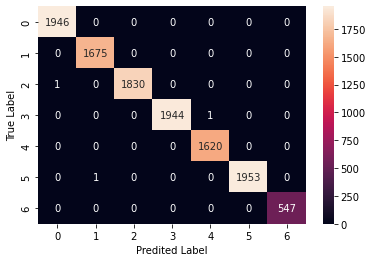

In [ ]:
display_metrics(y_train, ytrain_predic)

Recall: 0.6216726649708395
Precision: 0.6194308472341146
Accuracy: 0.5890625
f1_score: 0.6104621438137238


All metrics:
              precision    recall  f1-score   support

    Angry(0)       0.59      0.79      0.68       221
Disgusted(1)       0.57      0.47      0.52       188
  Fearful(2)       0.65      0.36      0.46       216
    Happy(3)       0.52      0.48      0.50       222
  Neutral(4)       0.54      0.62      0.57       175
      Sad(5)       0.62      0.75      0.68       213
Surprised(6)       0.85      0.89      0.87        45

    accuracy                           0.59      1280
   macro avg       0.62      0.62      0.61      1280
weighted avg       0.59      0.59      0.58      1280





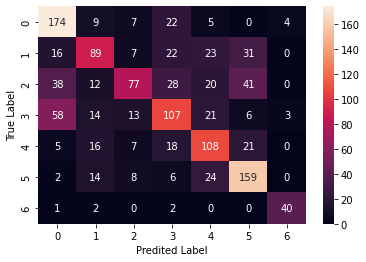

In [ ]:
display_metrics(y_test, ytest_predic)

## Guardando el Modelo

In [ ]:
#Descomentar si se desea guardar el modelo
# import pickle
# pickle.dump(grid, open('models/RF_model.model','wb'))